In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import DataRead
from sklearn.model_selection import train_test_split

In [2]:
characters, df_captcha, images = DataRead.readData()

In [3]:
df_captcha

,path,label
0,dataSet\4gycb.png,4gycb
1,dataSet\mxnw4.png,mxnw4
2,dataSet\mmg38.png,mmg38
3,dataSet\dxwcw.png,dxwcw
4,dataSet\b4d7c.png,b4d7c
...,...,...
1035,dataSet\4cn7b.png,4cn7b
1036,dataSet\fcmem.png,fcmem
1037,dataSet\yf424.png,yf424
1038,dataSet\fdpgd.png,fdpgd


Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


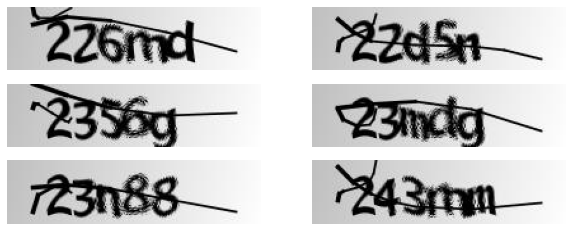

In [32]:
sample_images = images[:6]
_,ax = plt.subplots(3,2, figsize=(10,4))
for i in range(len(sample_images)):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [5]:
print("Tüm veri kümesindeki unqiue karakterlerinin sayısı: ", len(characters))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(df_captcha))
df_captcha.head()

Tüm veri kümesindeki unqiue karakterlerinin sayısı:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset:  1040


,path,label
0,dataSet\4gycb.png,4gycb
1,dataSet\mxnw4.png,mxnw4
2,dataSet\mmg38.png,mmg38
3,dataSet\dxwcw.png,dxwcw
4,dataSet\b4d7c.png,b4d7c


In [6]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

### Veri Setinin Train ve Test için Ayrılması

In [7]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(df_captcha, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))


Number of training samples:  832
Number of validation samples:  208


In [8]:
# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}
# labels_to_char
char_to_labels

{'2': 0,
 '3': 1,
 '4': 2,
 '5': 3,
 '6': 4,
 '7': 5,
 '8': 6,
 'b': 7,
 'c': 8,
 'd': 9,
 'e': 10,
 'f': 11,
 'g': 12,
 'm': 13,
 'n': 14,
 'p': 15,
 'w': 16,
 'x': 17,
 'y': 18}

In [9]:
# gelen chapta eğer bizim karakter dizimizden farklı bir karakter içeriyorsa false dönen fonksiyon
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

In [10]:
# Çok büyük bir veri kümesi olmadığı için dizileri bellekte saklayın
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    #resimleri siyah beyaza çevirme
    for i in range(num_items):
        img = cv2.imread(df["path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # eğer karakter kontrolü boş dönüyorsa ekleme
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [11]:
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

Number of training images:  (832, 50, 200)
Number of training labels:  (832,)


In [12]:
# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of validation images:  (208, 50, 200)
Number of validation labels:  (208,)


In [13]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset. (Belirli bir veri kümesinden toplu işler üretir.)
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
#         print(batch_len)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Resmi alın ve transpoze edin
            img = self.data[idx].T
            # 2. Ekstra boyut ekleyin
            img = np.expand_dims(img, axis=-1)
            # 3. İlgili etiketi alın
            text = self.labels[idx]
            # 4. Çifti yalnızca captcha geçerliyse dahil edin
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [14]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=200
img_height=50 

# Factor  by which the image is going to be downsampled(Pooling (Downsampling) Layer sayesinde görselde yer alan ağırlık azaltılmaya çalışılır ve azaltılan bu ağırlık doğrultusunda resmin parametrelere uygunluğu test edilir. )
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=5

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [15]:
print(train_data_generator[0])

({'input_data': array([[[[0.7529412 ],
         [0.7529412 ],
         [0.7529412 ],
         ...,
         [0.7647059 ],
         [0.7647059 ],
         [0.7647059 ]],

        [[0.7529412 ],
         [0.7529412 ],
         [0.7529412 ],
         ...,
         [0.7647059 ],
         [0.7647059 ],
         [0.7647059 ]],

        [[0.7529412 ],
         [0.7529412 ],
         [0.7529412 ],
         ...,
         [0.7647059 ],
         [0.7647059 ],
         [0.7647059 ]],

        ...,

        [[0.9843137 ],
         [0.9843137 ],
         [0.9843137 ],
         ...,
         [0.99607843],
         [0.99607843],
         [0.99607843]],

        [[0.9843137 ],
         [0.9843137 ],
         [0.9843137 ],
         ...,
         [0.99607843],
         [0.99607843],
         [0.99607843]],

        [[0.9843137 ],
         [0.9843137 ],
         [0.9843137 ],
         ...,
         [0.99607843],
         [0.99607843],
         [0.99607843]]],


       [[[0.7529412 ],
         [0.7529412 ]

Model kısmında ilk olarak Conv.layer ile modele başlanmıştır. Burada 32 ve 64 adet 3x3 lik filtreler kullanılmıştır.
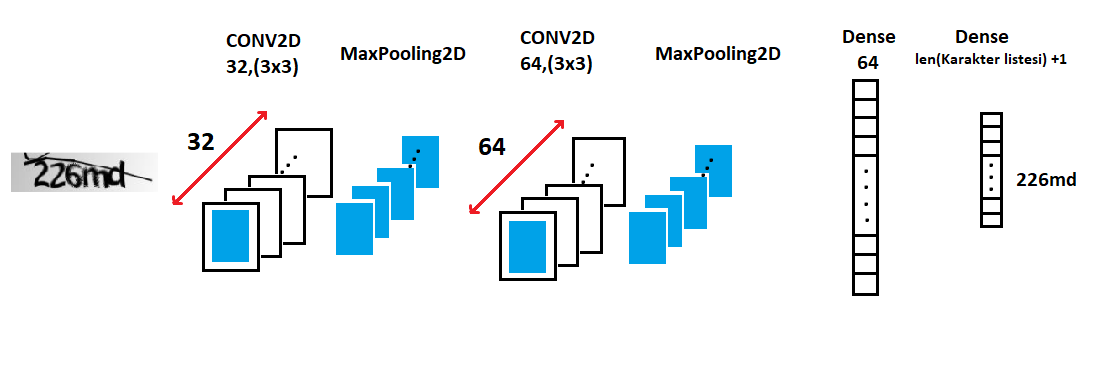

In [16]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
#     x = keras.layers.Flatten()
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x) #64 gizli katman
    x = layers.Dropout(0.2)(x)
    
#     # RNNs
#     x = layers.Bidirectional(layers.LSTM(128,
#                                          return_sequences=True,
#                                          dropout=0.2))(x)
#     x = layers.Bidirectional(layers.LSTM(64,
#                                          return_sequences=True,
#                                          dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

Bu hiperparametreler modelimizin daha çabuk eğitilmesinde etkili. Burada lr, learning rate, yani öğrenme hızımız. Decay parametresi öğrenme hızımızı zamanla azaltıyor. Momentum yöntemini kullanıyoruz. Bu parametre için genelde 0.9 değeri kullanılıyor. Momentum yönteminde bir hız vektörü tutuyoruz ve her adımda bunu update ediyoruz. Nesterov momentumu ise bunu biraz daha akıllı yapan, büyük bir adım attıktan sonra kendini düzelten bir yöntem.
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [17]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['input_data[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [18]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=40,
                    verbose=2)


Epoch 1/40
52/52 - 10s - loss: 48.2678 - val_loss: 16.9619 - 10s/epoch - 185ms/step
Epoch 2/40
52/52 - 8s - loss: 16.4606 - val_loss: 16.8295 - 8s/epoch - 151ms/step
Epoch 3/40
52/52 - 8s - loss: 16.2217 - val_loss: 15.4953 - 8s/epoch - 150ms/step
Epoch 4/40
52/52 - 8s - loss: 14.9335 - val_loss: 12.7927 - 8s/epoch - 149ms/step
Epoch 5/40
52/52 - 8s - loss: 12.1520 - val_loss: 9.9618 - 8s/epoch - 154ms/step
Epoch 6/40
52/52 - 8s - loss: 9.3738 - val_loss: 7.3991 - 8s/epoch - 160ms/step
Epoch 7/40
52/52 - 9s - loss: 7.3214 - val_loss: 5.1397 - 9s/epoch - 167ms/step
Epoch 8/40
52/52 - 8s - loss: 5.8161 - val_loss: 3.9793 - 8s/epoch - 146ms/step
Epoch 9/40
52/52 - 9s - loss: 4.6721 - val_loss: 3.5607 - 9s/epoch - 166ms/step
Epoch 10/40
52/52 - 8s - loss: 4.0533 - val_loss: 2.8960 - 8s/epoch - 158ms/step
Epoch 11/40
52/52 - 9s - loss: 3.5890 - val_loss: 2.4247 - 9s/epoch - 180ms/step
Epoch 12/40
52/52 - 9s - loss: 3.2115 - val_loss: 2.2156 - 9s/epoch - 172ms/step
Epoch 13/40
52/52 - 8s - l

In [19]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

<AxesSubplot:>

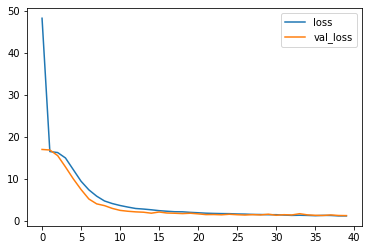

In [20]:
kayipVeri = pd.DataFrame(model.history.history)
kayipVeri
edKaybi1 = pd.DataFrame(kayipVeri["loss"])
edKaybi2 = pd.DataFrame(kayipVeri["val_loss"])
edKaybi = pd.merge(edKaybi1,edKaybi2, right_index=True,left_index=True)
edKaybi.plot()

In [21]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [22]:
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Ground truth: 6b46g 	 Predicted: 6b46g
Ground truth: n7dyb 	 Predicted: n7dyb
Ground truth: ddpyb 	 Predicted: ddpyb
Ground truth: bdg84 	 Predicted: bdg84
Ground truth: 4ycex 	 Predicted: 4ycex
Ground truth: 478nx 	 Predicted: 478nx
Ground truth: b5fm7 	 Predicted: b5fm7
Ground truth: nxcmn 	 Predicted: nxcn
Ground truth: gnbn4 	 Predicted: gnbn4
Ground truth: x6b5m 	 Predicted: x6b5m
Ground truth: b6f2p 	 Predicted: b6f2p
Ground truth: xce8d 	 Predicted: xce8d
Ground truth: nn4wx 	 Predicted: nn4wx
Ground truth: m457d 	 Predicted: m457d
Ground truth: 5ywwf 	 Predicted: 5ywwf
Ground truth: d378n 	 Predicted: d378n
